## GCN (PyTorch) with random graphs

In [1]:
import torch
from torch import nn

import support
from support import gml

### Generate a random graph

In [2]:
num_nodes = 16
edges = support.gen_rand_edges(num_nodes, directed=False)
print('edges:', edges)

edges: [(0, 8), (8, 0), (1, 14), (14, 1), (2, 7), (7, 2), (3, 12), (12, 3), (3, 13), (13, 3), (4, 9), (9, 4), (5, 7), (7, 5), (6, 11), (11, 6), (7, 4), (4, 7), (8, 6), (6, 8), (9, 1), (1, 9), (10, 1), (1, 10), (11, 10), (10, 11), (12, 7), (7, 12), (12, 6), (6, 12), (13, 9), (9, 13), (13, 0), (0, 13), (14, 4), (4, 14), (14, 15), (15, 14), (15, 0), (0, 15)]


In [3]:
g = gml.Graph(num_nodes, edges)
g

Graph(n_nodes=16, n_edges=40, device=cpu,
      ndata=Namespace(_dim=16),
      edata=Namespace(_dim=40))

In [4]:
adj = g.adj()
print(adj)
print(adj.shape)

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]], dtype=torch.int32)
torch.Size([16, 16])


### Assign ground truth labels

In [5]:
num_classes = 3
g.ndata.label = torch.randint(0, num_classes, (num_nodes,))
print(f"labels: {g.ndata.label}")

labels: tensor([2, 1, 0, 2, 1, 1, 1, 2, 0, 2, 2, 2, 0, 2, 2, 0])


### Plot as points to visualize

In [6]:
g.ndata.point = torch.rand(num_nodes, 2)
print(f"points:\n{g.ndata.point}")

points:
tensor([[6.1959e-01, 2.1411e-01],
        [5.6122e-01, 8.9680e-01],
        [1.8413e-01, 2.1913e-01],
        [5.2482e-01, 5.3622e-02],
        [4.2910e-01, 7.7194e-02],
        [8.0843e-01, 5.9283e-01],
        [2.2770e-01, 7.4363e-01],
        [7.5685e-01, 9.4380e-01],
        [7.6406e-01, 6.1233e-01],
        [4.3535e-01, 7.7697e-01],
        [9.4301e-01, 8.4057e-01],
        [3.1483e-01, 2.2857e-01],
        [6.8213e-01, 2.0027e-04],
        [6.8499e-01, 8.4005e-01],
        [4.8298e-01, 3.6104e-01],
        [5.6322e-01, 2.7672e-01]])


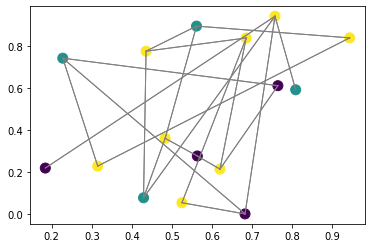

In [7]:
support.plot_graph(adj, g.ndata.point, g.ndata.label)

### Setup input node features

In [8]:
g.ndata.feats = torch.eye(num_nodes)
print(g.ndata.feats.shape)

torch.Size([16, 16])


### Setup GCN model

In [9]:
adj_norm = gml.gcn.renormalize_adjacency(adj)

In [10]:
model = gml.GCN(2, in_dim=num_nodes, out_dim=num_classes)
model

GCN(
  (layers): ModuleList(
    (0): AdjConv(
      (linear): Linear(in_features=16, out_features=16, bias=False)
      (act): ReLU()
    )
    (1): AdjConv(
      (linear): Linear(in_features=16, out_features=3, bias=False)
    )
  )
)

### Feed inputs foward in model

In [11]:
with torch.no_grad():
    logits = model(adj_norm, g.ndata.feats)
print(logits)
print(logits.shape)

tensor([[ 0.0141,  0.0077,  0.0170],
        [ 0.0055,  0.0156,  0.0107],
        [-0.0227,  0.0322, -0.0103],
        [ 0.0273,  0.0119,  0.0234],
        [ 0.0129,  0.0030,  0.0194],
        [ 0.0361,  0.0158,  0.0333],
        [-0.0102,  0.0131,  0.0060],
        [ 0.0061,  0.0214,  0.0139],
        [-0.0098,  0.0040,  0.0109],
        [ 0.0223,  0.0142,  0.0198],
        [-0.0048,  0.0332, -0.0037],
        [-0.0157,  0.0346, -0.0027],
        [ 0.0092,  0.0125,  0.0168],
        [ 0.0265,  0.0178,  0.0271],
        [ 0.0029, -0.0029,  0.0028],
        [-0.0004, -0.0041,  0.0046]])
torch.Size([16, 3])


### Classify the nodes

In [12]:
softmax = nn.Softmax(dim=1)
probs = softmax(logits)
print(probs)
print(probs.shape)

tensor([[0.3337, 0.3316, 0.3347],
        [0.3316, 0.3350, 0.3334],
        [0.3259, 0.3442, 0.3299],
        [0.3355, 0.3304, 0.3342],
        [0.3337, 0.3304, 0.3359],
        [0.3359, 0.3291, 0.3350],
        [0.3290, 0.3367, 0.3343],
        [0.3308, 0.3359, 0.3334],
        [0.3295, 0.3341, 0.3364],
        [0.3345, 0.3318, 0.3337],
        [0.3290, 0.3417, 0.3293],
        [0.3263, 0.3431, 0.3306],
        [0.3321, 0.3332, 0.3347],
        [0.3342, 0.3313, 0.3344],
        [0.3340, 0.3321, 0.3340],
        [0.3332, 0.3320, 0.3348]])
torch.Size([16, 3])


### Check against ground truth

In [13]:
y_pred = probs.argmax(dim=1)
correct = (y_pred == g.ndata.label).type(torch.float).sum().item()
accuracy = (correct / num_nodes) * 100

print(f"y_predicted: {y_pred}")
print(f"true_labels: {g.ndata.label}")
print(f"accuracy: {accuracy:>0.1f}%")

y_predicted: tensor([2, 1, 1, 0, 2, 0, 1, 1, 2, 0, 1, 1, 2, 2, 0, 2])
true_labels: tensor([2, 1, 0, 2, 1, 1, 1, 2, 0, 2, 2, 2, 0, 2, 2, 0])
accuracy: 25.0%


### Try to plot it

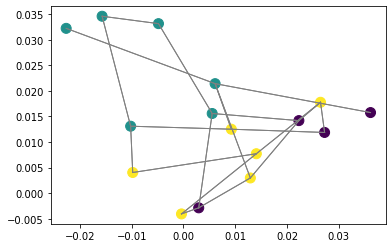

In [14]:
support.plot_graph(adj, logits, y_pred)

### Let's do some training

In [15]:
learning_rate = 0.01
epochs = 200

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
for i in range(epochs):
    print(f"Epoch {i+1:<3} ------")
    loss = support.train(model, g, adj_norm, loss_fn, optimizer)
    print(f"loss: {loss:>7f}")
    accuracy = support.evaluate(model, g, adj_norm)
    print(f"accuracy: {accuracy:>0.1f}%")
    print()
print("done")

Epoch 1   ------
loss: 1.101875
accuracy: 37.5%

Epoch 2   ------
loss: 1.097967
accuracy: 43.8%

Epoch 3   ------
loss: 1.094118
accuracy: 50.0%

Epoch 4   ------
loss: 1.090327
accuracy: 50.0%

Epoch 5   ------
loss: 1.086513
accuracy: 50.0%

Epoch 6   ------
loss: 1.082579
accuracy: 50.0%

Epoch 7   ------
loss: 1.078468
accuracy: 50.0%

Epoch 8   ------
loss: 1.074219
accuracy: 50.0%

Epoch 9   ------
loss: 1.069765
accuracy: 50.0%

Epoch 10  ------
loss: 1.065018
accuracy: 50.0%

Epoch 11  ------
loss: 1.059976
accuracy: 50.0%

Epoch 12  ------
loss: 1.054615
accuracy: 50.0%

Epoch 13  ------
loss: 1.048947
accuracy: 50.0%

Epoch 14  ------
loss: 1.042960
accuracy: 50.0%

Epoch 15  ------
loss: 1.036711
accuracy: 50.0%

Epoch 16  ------
loss: 1.030213
accuracy: 50.0%

Epoch 17  ------
loss: 1.023508
accuracy: 50.0%

Epoch 18  ------
loss: 1.016680
accuracy: 50.0%

Epoch 19  ------
loss: 1.009699
accuracy: 50.0%

Epoch 20  ------
loss: 1.002634
accuracy: 50.0%

Epoch 21  ------
los

### Now try visualizing it

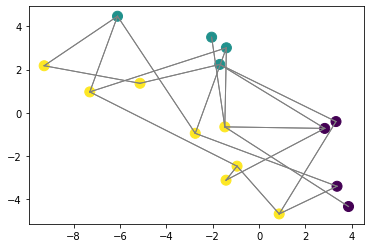

In [18]:
with torch.no_grad():
    logits = model(adj_norm, g.ndata.feats)
y_pred = softmax(logits).argmax(dim=1)

support.plot_graph(adj, logits, y_pred)